This week we'll explore the relationship between the average gross salary and the CPI in Latvia.

In [1]:
from datetime import date

from pycspwrapper import LVStat
from matplotlib import pyplot as plt
import polars as pl

%matplotlib inline

# Load the data

We're interested in two CSP tables:
1. Monthly average salary - https://data.stat.gov.lv/pxweb/lv/OSP_PUB/START__EMP__DS__DSV/DSV010m
2. CPI - https://data.stat.gov.lv/pxweb/lv/OSP_PUB/START__VEK__PC__PCI/PCI020m

At the time of writing, the latest available data for DSV010m is December 2023, so let's look at the 5 year period, January 2019 - December 2023.

In [2]:
def data_to_df(data):
    '''Transform the data returned by CSP API into a dataframe.'''
    key_cols = []
    val_cols = []
    column_values = {}
    for col in data['columns']:
        if col['type'] == 'c':
            val_cols.append(col['code'])
        else:
            key_cols.append(col['code'])
        column_values[col['code']] = []
    for row in data['data']:
        for col, value in zip(key_cols, row['key']):
            if col == "TIME":
                # Transform time values to date.
                if len(value) == 4:
                    value = date(int(value), 1, 1)
                elif value[4] == 'M':
                    split_time = value.split('M', 1)
                    value = date(int(split_time[0]), int(split_time[1]), 1)
            column_values[col].append(value)
        for col, value in zip(val_cols, row['values']):
            if value == '…':
                # Missing value.
                column_values[col].append(None)
            else:
                column_values[col].append(float(value))
    series = map(
        lambda kv: pl.Series(kv[0], kv[1]),
        column_values.items()
    )
    return pl.DataFrame(series)

In [3]:
START_YEAR = 2019
END_YEAR = 2024

time_query = [
    f'{y}M{m:02d}' for y in range(START_YEAR, END_YEAR) for m in range(1, 13)]

# Query the DSV010m table.
stat_salary = LVStat('lv', 'EMP', 'DS', 'DSV', 'DSV010m')
stat_salary.set_query(
    ContentsCode=["DSV010m"],  # EUR values
    GRS_NET=["GRS"],  # Gross salaries
    SECTOR=["TOTAL"],
    # Load one extra month to calculate differences later.
    TIME=time_query
)
salary_data_json = stat_salary.get_data()
salary_data_json

{'columns': [{'code': 'GRS_NET', 'text': 'Bruto/ Neto', 'type': 'd'},
  {'code': 'SECTOR', 'text': 'Sektors', 'type': 'd'},
  {'code': 'TIME', 'text': 'Laika periods', 'type': 't'},
  {'code': 'Strādājošo mēneša vidējā darba samaksa (eiro)',
   'text': 'Strādājošo mēneša vidējā darba samaksa (eiro)',
   'type': 'c'}],
 'comments': [],
 'data': [{'key': ['GRS', 'TOTAL', '2019M01'], 'values': ['1029']},
  {'key': ['GRS', 'TOTAL', '2019M02'], 'values': ['1007']},
  {'key': ['GRS', 'TOTAL', '2019M03'], 'values': ['1060']},
  {'key': ['GRS', 'TOTAL', '2019M04'], 'values': ['1075']},
  {'key': ['GRS', 'TOTAL', '2019M05'], 'values': ['1078']},
  {'key': ['GRS', 'TOTAL', '2019M06'], 'values': ['1074']},
  {'key': ['GRS', 'TOTAL', '2019M07'], 'values': ['1111']},
  {'key': ['GRS', 'TOTAL', '2019M08'], 'values': ['1079']},
  {'key': ['GRS', 'TOTAL', '2019M09'], 'values': ['1059']},
  {'key': ['GRS', 'TOTAL', '2019M10'], 'values': ['1089']},
  {'key': ['GRS', 'TOTAL', '2019M11'], 'values': ['1101

In [4]:
# Query the DSV010m table.
stat_cpi = LVStat('lv', 'VEK', 'PC', 'PCI', 'PCI020m')
stat_cpi.set_query(
    ContentsCode=["PCI020m3"],  # 2015=100 Index
    ECOICOP=["00"],  # All goods
    TIME=time_query
)
cpi_data_json = stat_cpi.get_data()
cpi_data_json

{'columns': [{'code': 'ECOICOP',
   'text': 'Grupas un apakšgrupas (ECOICOP)',
   'type': 'd'},
  {'code': 'TIME', 'text': 'Laika periods', 'type': 't'},
  {'code': 'Patēriņa cenu indeksi grupās un apakšgrupās (2015.gads=100)',
   'text': 'Patēriņa cenu indeksi grupās un apakšgrupās (2015.gads=100)',
   'type': 'c'}],
 'comments': [],
 'data': [{'key': ['00', '2019M01'], 'values': ['106.9']},
  {'key': ['00', '2019M02'], 'values': ['107.0']},
  {'key': ['00', '2019M03'], 'values': ['108.2']},
  {'key': ['00', '2019M04'], 'values': ['109.1']},
  {'key': ['00', '2019M05'], 'values': ['109.3']},
  {'key': ['00', '2019M06'], 'values': ['109.7']},
  {'key': ['00', '2019M07'], 'values': ['108.7']},
  {'key': ['00', '2019M08'], 'values': ['108.9']},
  {'key': ['00', '2019M09'], 'values': ['108.9']},
  {'key': ['00', '2019M10'], 'values': ['109.3']},
  {'key': ['00', '2019M11'], 'values': ['109.1']},
  {'key': ['00', '2019M12'], 'values': ['108.8']},
  {'key': ['00', '2020M01'], 'values': ['10

## Merge data into a single dataframe.

In [5]:
salary_df = data_to_df(salary_data_json)
salary_df

GRS_NET,SECTOR,TIME,Strādājošo mēneša vidējā darba samaksa (eiro)
str,str,date,f64
"""GRS""","""TOTAL""",2019-01-01,1029.0
"""GRS""","""TOTAL""",2019-02-01,1007.0
"""GRS""","""TOTAL""",2019-03-01,1060.0
"""GRS""","""TOTAL""",2019-04-01,1075.0
"""GRS""","""TOTAL""",2019-05-01,1078.0
…,…,…,…
"""GRS""","""TOTAL""",2023-08-01,1578.0
"""GRS""","""TOTAL""",2023-09-01,1530.0
"""GRS""","""TOTAL""",2023-10-01,1558.0


In [6]:
# Let's drop first two columns and rename the last column.
salary_df = salary_df.select(
    pl.col('TIME'),
    pl.col(salary_df.columns[-1]).alias('salary')
)
salary_df

TIME,salary
date,f64
2019-01-01,1029.0
2019-02-01,1007.0
2019-03-01,1060.0
2019-04-01,1075.0
2019-05-01,1078.0
…,…
2023-08-01,1578.0
2023-09-01,1530.0
2023-10-01,1558.0


In [7]:
# Same for the cpi_data
cpi_df = data_to_df(cpi_data_json)
cpi_df = cpi_df.select(
    pl.col('TIME'),
    pl.col(cpi_df.columns[-1]).alias('cpi')
)
cpi_df

TIME,cpi
date,f64
2019-01-01,106.9
2019-02-01,107.0
2019-03-01,108.2
2019-04-01,109.1
2019-05-01,109.3
…,…
2023-08-01,144.3
2023-09-01,143.8
2023-10-01,143.2


In [8]:
# Now we can combine the data into a single dataframe.
data = salary_df.join(cpi_df, on='TIME')
data

TIME,salary,cpi
date,f64,f64
2019-01-01,1029.0,106.9
2019-02-01,1007.0,107.0
2019-03-01,1060.0,108.2
2019-04-01,1075.0,109.1
2019-05-01,1078.0,109.3
…,…,…
2023-08-01,1578.0,144.3
2023-09-01,1530.0,143.8
2023-10-01,1558.0,143.2


# Explore the data

Let's see the best way to evaluate the relationship between the two metrics.

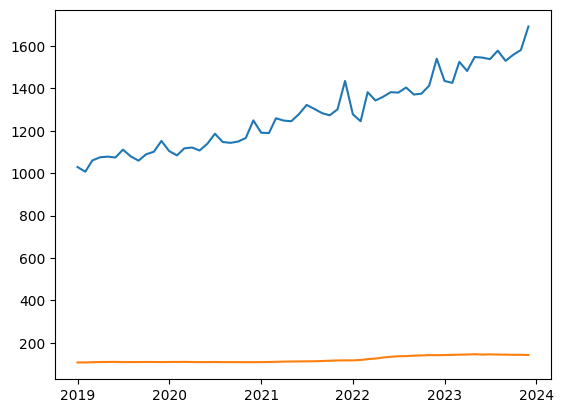

In [9]:
plt.plot(data['TIME'], data['salary'])
plt.plot(data['TIME'], data['cpi']);

Not very informative due to different scales, let's calculate the metrics relative to December 2018.

In [10]:
first_salary = data['salary'][0]
first_cpi = data['cpi'][0]
data = data.with_columns(
    (pl.col('salary') / first_salary).alias('salary_relative'),
    (pl.col('cpi') / first_cpi).alias('cpi_relative'),
)
data

TIME,salary,cpi,salary_relative,cpi_relative
date,f64,f64,f64,f64
2019-01-01,1029.0,106.9,1.0,1.0
2019-02-01,1007.0,107.0,0.97862,1.000935
2019-03-01,1060.0,108.2,1.030126,1.012161
2019-04-01,1075.0,109.1,1.044704,1.02058
2019-05-01,1078.0,109.3,1.047619,1.022451
…,…,…,…,…
2023-08-01,1578.0,144.3,1.533528,1.34986
2023-09-01,1530.0,143.8,1.48688,1.345182
2023-10-01,1558.0,143.2,1.514091,1.33957


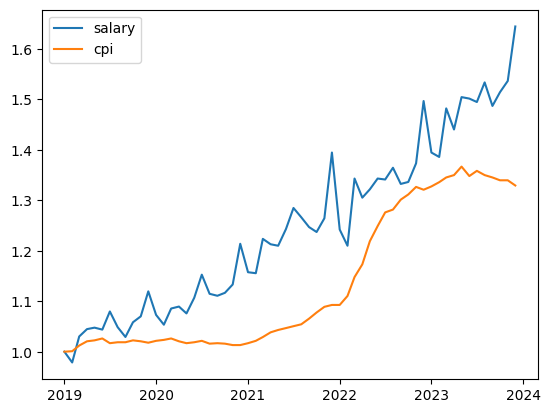

In [11]:
plt.plot(data['TIME'], data['salary_relative'], label='salary')
plt.plot(data['TIME'], data['cpi_relative'], label='cpi')
plt.legend();

What if we look at the change values?

In [12]:
data = data.with_columns(
    (pl.col('salary') / pl.col('salary').shift(1) - 1.0).alias('salary_change'),
    (pl.col('cpi') / pl.col('cpi').shift(1) - 1.0).alias('cpi_change'),
)
data

TIME,salary,cpi,salary_relative,cpi_relative,salary_change,cpi_change
date,f64,f64,f64,f64,f64,f64
2019-01-01,1029.0,106.9,1.0,1.0,null,null
2019-02-01,1007.0,107.0,0.97862,1.000935,-0.02138,0.000935
2019-03-01,1060.0,108.2,1.030126,1.012161,0.052632,0.011215
2019-04-01,1075.0,109.1,1.044704,1.02058,0.014151,0.008318
2019-05-01,1078.0,109.3,1.047619,1.022451,0.002791,0.001833
…,…,…,…,…,…,…
2023-08-01,1578.0,144.3,1.533528,1.34986,0.026008,-0.006198
2023-09-01,1530.0,143.8,1.48688,1.345182,-0.030418,-0.003465
2023-10-01,1558.0,143.2,1.514091,1.33957,0.018301,-0.004172


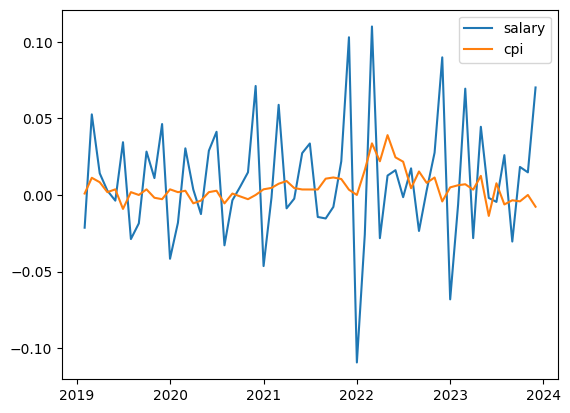

In [13]:
plt.plot(data['TIME'], data['salary_change'], label='salary')
plt.plot(data['TIME'], data['cpi_change'], label='cpi')
plt.legend();

Not too informative too.

What if we divide salary relative to 2018 by CPI relative to 2018?

In [14]:
data = data.with_columns(
    (pl.col('salary_relative') - pl.col('cpi_relative')).alias('salary_vs_cpi')
)
data

TIME,salary,cpi,salary_relative,cpi_relative,salary_change,cpi_change,salary_vs_cpi
date,f64,f64,f64,f64,f64,f64,f64
2019-01-01,1029.0,106.9,1.0,1.0,null,null,0.0
2019-02-01,1007.0,107.0,0.97862,1.000935,-0.02138,0.000935,-0.022315
2019-03-01,1060.0,108.2,1.030126,1.012161,0.052632,0.011215,0.017965
2019-04-01,1075.0,109.1,1.044704,1.02058,0.014151,0.008318,0.024124
2019-05-01,1078.0,109.3,1.047619,1.022451,0.002791,0.001833,0.025168
…,…,…,…,…,…,…,…
2023-08-01,1578.0,144.3,1.533528,1.34986,0.026008,-0.006198,0.183668
2023-09-01,1530.0,143.8,1.48688,1.345182,-0.030418,-0.003465,0.141698
2023-10-01,1558.0,143.2,1.514091,1.33957,0.018301,-0.004172,0.174522


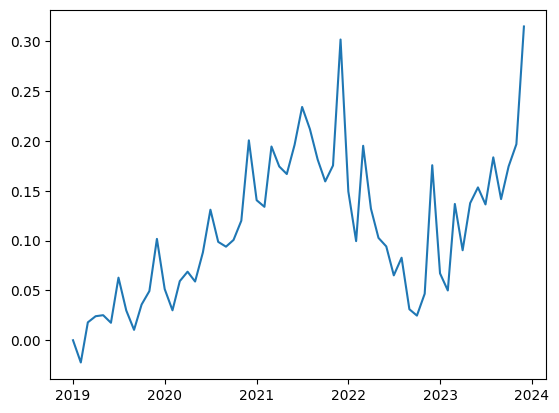

In [15]:
plt.plot(data['TIME'], data['salary_vs_cpi']);

# Final graph

I'll stick to the graph displaying both salary and CPI relative to the first month. Let's make it nicer!

Will use plotly this time.

In [16]:
# Tranform data to percentage values.
data = data.with_columns(
    pl.col('salary_relative') * 100 - 100,
    pl.col('cpi_relative') * 100 - 100,
    pl.col('salary_vs_cpi') * 100
)
data

TIME,salary,cpi,salary_relative,cpi_relative,salary_change,cpi_change,salary_vs_cpi
date,f64,f64,f64,f64,f64,f64,f64
2019-01-01,1029.0,106.9,0.0,0.0,null,null,0.0
2019-02-01,1007.0,107.0,-2.137998,0.093545,-0.02138,0.000935,-2.231543
2019-03-01,1060.0,108.2,3.012634,1.21609,0.052632,0.011215,1.796544
2019-04-01,1075.0,109.1,4.47036,2.057998,0.014151,0.008318,2.412361
2019-05-01,1078.0,109.3,4.761905,2.245089,0.002791,0.001833,2.516816
…,…,…,…,…,…,…,…
2023-08-01,1578.0,144.3,53.35277,34.985968,0.026008,-0.006198,18.366801
2023-09-01,1530.0,143.8,48.688047,34.518241,-0.030418,-0.003465,14.169805
2023-10-01,1558.0,143.2,51.409135,33.956969,0.018301,-0.004172,17.452166


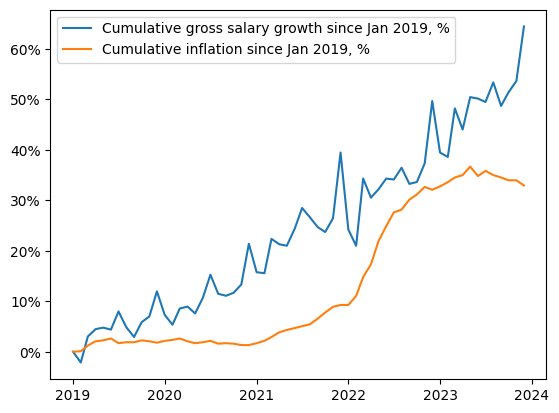

In [17]:
import matplotlib.ticker as mtick

ax = plt.subplot()

ax.plot(data['TIME'],
         data['salary_relative'],
         label=f'Cumulative gross salary growth since Jan {START_YEAR}, %')
ax.plot(data['TIME'],
         data['cpi_relative'], label=f'Cumulative inflation since Jan {START_YEAR}, %')

# Format the date.
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

plt.legend();

In [18]:
import plotly.express as px

fig = px.line(
    data,
    'TIME',
    ['salary_relative', 'cpi_relative'],
    title=f"Average Salary and Inflation in Latvia, {START_YEAR}–{END_YEAR-1}"
)
fig.update_xaxes(
    dtick="M3",
    tickformat="%b\n%Y")
fig.update_yaxes(
    ticksuffix="%")
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        title=None,
    ),
    width=720,
    font_size=12,
    margin={'l': 0, 't': 32, 'r': 10, 'b': 55},
    xaxis_title=None,
    yaxis_title=f'Growth since January {START_YEAR}')

# Replace the label names.
legend_names = {
    'salary_relative': f'Average gross salary',
    'cpi_relative': f'Inflation',
}
fig.for_each_trace(lambda t: t.update(name=legend_names[t.name],
                                      legendgroup=legend_names[t.name],
                                      hovertemplate=t.hovertemplate.replace(
                                          t.name, legend_names[t.name])
                                      )
                   )

fig.add_annotation(
    xref="paper",
    yref="paper",
    x=-0.07,
    y=-0.15,
    text=f"Data source: stat.gov.lv, tables {stat_salary.ids[-1]} and {stat_cpi.ids[-1]}",
    showarrow=False)

# Allow saving in good quality.
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.show(config=config)